# Práctica 5: Regresión lineal regularizada: sesgo y varianza

### Jorge Villarrubia Elvira y Juan Carlos Villanueva Quirós

### 1. Regresión lineal regularizada
En esta práctica comprobaremos los efectos del sesgo (bias) y la varianza (variance). 

Para ello, en esta primera parte cargamos los ficheros de datos de *ex5data1.mat* que se corresponden con los datos históricos sobre el agua que ha derramado una presa en base a los cambios del nivel del agua. Obtenemos de estos datos un diccionario *dic* que contiene los datos de entrenamiento, validación y prueba.

Además, implementamos las funciones de coste y gradiente de la regresión lineal regularizada y usamos la función *scipy.optimize.minimize* para encontrar el valor óptimo $\theta$ que minimiza el error sobre los ejemplos de entrenamiento.

In [289]:
#Importamos todas las librerias y funciones externas que usamos
from scipy.io import loadmat
from scipy.optimize import minimize
from matplotlib import pyplot as plt

import numpy as np

In [290]:
def fun_coste(theta, X, Y, lamda) :
    """
    Args:
        theta: vector con los parametros de la regresion
        X: vector con los valores de entrada
        Y: vector con los valores reales
        lamda: coeficiente de regularizacion
     
    Calcula el coste de la regresion lineal regularizada
    """
    Y_ravel = Y.ravel()
    m = len(X)
    regu = (lamda * np.sum(theta[1:]**2)) / (2*m)
    return np.sum((fun_h(theta, X) - Y_ravel)**2) / (2*m) + regu

def fun_h(theta, X) :
    """
    Args:
        theta: vector con los parametros de la regresion
        X: vector con los valores de entrada
    
    Dados los parametros y el vector X de valores a predecir, evalua la regresion en los puntos X.
    """
    return np.matmul(X, theta)

def gradiente(theta, X, Y, lamda) :
    """
    Args:
        theta: vector con los parametros de la regresion
        X: vector con los valores de entrada
        Y: vector con los valores reales
        lamda: coeficiente de regularizacion
    
    Calcula el gradiente de la regresion lineal regularizada
    """
    Y_ravel = Y.ravel()
    m = len(X)
    regu = lamda/m * theta
    regu[0] = 0
    return  np.matmul(X.T, (fun_h(theta, X) - Y_ravel)) / m + regu

In [291]:
#Cargamos a un diccionario los datos del fichero 
dic = loadmat("ex5data1.mat")
X = dic['X']
Y = dic['y']

m = np.shape(X)[0]
#Anadimos unos a los valores de entrada (termino independiente)
X_ones = np.hstack([np.ones([m, 1]), X])
#Inicializamos los parametros y coeficientes de regularizacion
theta = np.ones(2)
lamda = 1

#Calculamos coste y gradiente
coste = fun_coste(theta, X_ones, Y, lamda)
grad = gradiente(theta, X_ones, Y, lamda)
print("Coste: ", coste, "\nGradiente:", grad)

Coste:  303.9931922202643 
Gradiente: [-15.30301567 598.25074417]


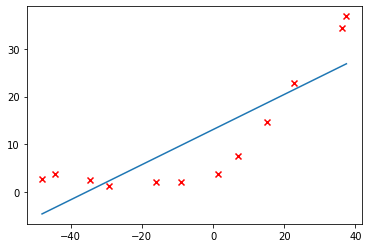

In [292]:
theta = np.ones(2)
lamda = 0
#Calculamos valor thetas optimos
fun = minimize(fun=fun_coste, x0 = theta, args=(X_ones, Y, lamda))

#Imprimimos la recta por pantalla
step = 500
grid = np.linspace(X.min(), X.max(), step)
grid_ones = np.hstack([np.ones([step,1]), grid.reshape(step,1)])
plt.scatter(X, Y, marker = 'x', color = 'red')
plt.plot(grid, fun_h(fun.x, grid_ones))
plt.show()

Como podemos comprobar, el coste, gradiente y recta nos quedan idénticos a los valores que debemos obtener, como describe el enunciado. 

### 2. Curvas de aprendizaje
A continuación, vamos a obtener las curvas de aprendizaje para identificar situaciones de sesgo (underfitting) y varianza (overfitting).

Para ello, repetimos el entrenamiento de regresión lineal utilizando diferentes subconjuntos de los datos de entrenamiento. En concreto, usaremos $X[0:i]$ e $Y[0:i]$. Después, comparamos el error sobre el subconjunto de entrenamiento con el error con el subconjunto de validación.

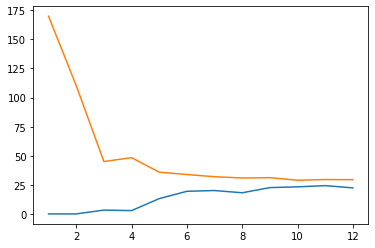

In [293]:
#Obtenemos los datos de validacion
Xval = dic['Xval']
Yval = dic['yval']
Xval_ones = np.hstack([np.ones([np.shape(Xval)[0], 1]), Xval])

#Inicializamos thetas y vectores de coste
costesTrain = []
costesVal = []
theta = np.ones(2)

#Para cada subconjunto X[0:i] de los datos de entrenamiento
for i in range(1,m+1):
    #Calculamos thetas optimas y guardamos los errores
    fun = minimize(fun=fun_coste, x0 = theta, args=(X_ones[0:i], Y[0:i], 0))
    costesTrain.append(fun_coste(fun.x, X_ones[0:i], Y[0:i], 0))
    costesVal.append(fun_coste(fun.x, Xval_ones, Yval, 0))

#Imprimimos por pantalla los costes resultantes
plt.plot(range(1,m+1), costesTrain)
plt.plot(range(1,m+1), costesVal)
plt.show()

Obtenemos la gráfica que nos debe resultar según el enunciado. Como podemos apreciar, ambos errores se aproximan considerablemente al aumentar el número de ejemplos de entrenamiento. Esto indica que el aprendizaje está sesgado y es necesario utilizar una hipótesis más expresiva que sea capaz de ajustarse mejor a los ejemplos de entrenamiento.

### 3. Regresión polinomial
Como ya hemos visto en prácticas anteriores, podemos conseguir un mayor ajuste a los datos de entrenamiento usando combinaciones polinómicas de los atributos de los datos de entrada. En nuestro caso, usaremos como hipótesis un polinomio:
$h_\theta(x) = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + ... + \theta_p x_p$

Para ello, implementamos una función que genera los nuevos datos de entrenamiento a partir de los originales. Además, implementamos otra función para normalizar los atributos resultantes, y de este modo evitar las grandes diferencias de rango.

Por último, aplicamos el método de regresión lineal con un polinomio de grado $p = 8$.

In [294]:
def build_polynomial_data(X, p):
    """
    Args:
        X: Datos de entrada (matriz m x 1)
        p: Grado del polinomio
    
    Dados unos datos de entrada, genera los nuevos datos de entrenamiento, que seran
    una matriz m x p en la que en la columna i tendra los valores X^i.
    """
    aux = X
    for i in range(2, p+1):
        aux = np.hstack([aux, np.reshape(X[:, 0]**i, (X[:,0].shape[0],1))])
    return aux

def normalize_data(X):
    """
    Args:
        X: Datos de entrada
        
    Dados unos datos de entrada, los normaliza haciendo (datos - media) / desviacion_estandar.
    Ademas, devuelve las medias y desviaciones estandar obtenidas
    """
    
    media = np.mean(X, axis = 0)
    desviacion = np.std(X, axis = 0)
    return (X - media) / desviacion, media, desviacion

def normalize_data_params(X, media, desviacion):
    """
    Args:
        X: Datos de entrada
        media:
        desviacion:
    Dados unos datos de entrada, media y desviacion, realiza la normalizacion
    """
    return (X - media) / desviacion

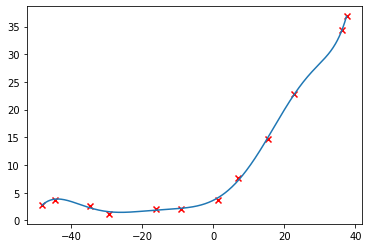

In [295]:
#Generamos los nuevos datos de entrada, los normalizamos y les anadimos unos.
p = 8
X_poly_norm, media, desviacion = normalize_data(build_polynomial_data(X, p))
X_poly_norm_ones = np.hstack([np.ones([X_poly_norm.shape[0], 1]), X_poly_norm])

#Obtenemos los thetas optimos
theta = np.ones(p+1)
fun = minimize(fun=fun_coste, x0 = theta, args=(X_poly_norm_ones, Y, 0))

#Imprimimos por pantalla hipotesis obtenida
step = 500
grid = np.linspace(X.min(), X.max(), step)
#Es necesario normalizar los valores a predecir con la misma transformacion que a los de entrenamiento
grid_poly = normalize_data_params(build_polynomial_data(np.reshape(grid, (step,1)), p), media, desviacion)

grid_poly_ones = np.hstack([np.ones([step,1]), grid_poly.reshape(step,p)])
plt.scatter(X, Y, marker = 'x', color = 'red')
plt.plot(grid, fun_h(fun.x, grid_poly_ones))
plt.show()

A continuación, generamos las curvas de aprendizaje para la hipótesis polinomial, utilizando la misma técnica del apartado anterior.

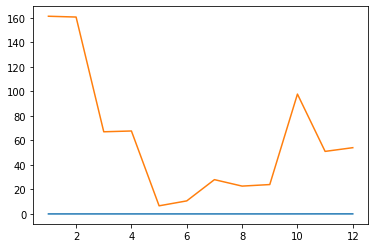

In [296]:
costesTrain = []
costesVal = []
theta = np.zeros(p+1)

#Generamos los datos de validacion, normalizamos y anadimos unos
Xval_norm = normalize_data_params(build_polynomial_data(Xval, p), media, desviacion)
Xval_norm_ones = np.hstack([np.ones([Xval_norm.shape[0], 1]), Xval_norm])

for i in range(1,m+1):    
    fun = minimize(fun=fun_coste, x0 = theta, args=(X_poly_norm_ones[0:i], Y[0:i], 0))
    costesTrain.append(fun_coste(fun.x, X_poly_norm_ones[0:i], Y[0:i], 0))
    costesVal.append(fun_coste(fun.x, Xval_norm_ones, Yval_ravel, 0))

#Imprimimos por pantalla los costes obtenidos
plt.plot(range(1,m+1), costesTrain)
plt.plot(range(1,m+1), costesVal)
plt.show()

Por último, probamos el efecto que tiene el término de regularización repitiendo el proceso para $\lambda = 1$ y $\lambda = 100$

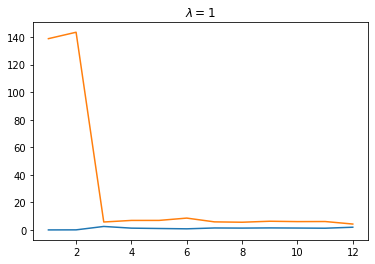

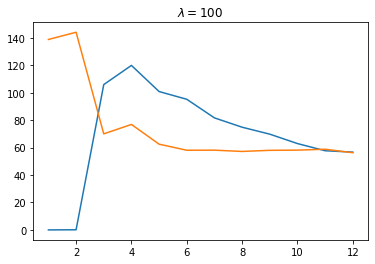

In [297]:
costesTrainOne = []
costesTrainTwo = []
costesValOne = []
costesValTwo = []
theta = np.zeros(p+1)

for i in range(1,m+1):    
    #Coeficiente regularizacion igual a 1
    fun = minimize(fun=fun_coste, x0 = theta, args=(X_poly_norm_ones[0:i], Y[0:i], 1))
    costesTrainOne.append(fun_coste(fun.x, X_poly_norm_ones[0:i], Y[0:i], 0))
    costesValOne.append(fun_coste(fun.x, Xval_norm_ones, Yval_ravel, 0))

    #Coeficiente regularizacion igual a 100
    fun = minimize(fun=fun_coste, x0 = theta, args=(X_poly_norm_ones[0:i], Y[0:i], 100))    
    costesTrainTwo.append(fun_coste(fun.x, X_poly_norm_ones[0:i], Y[0:i], 0))
    costesValTwo.append(fun_coste(fun.x, Xval_norm_ones, Yval_ravel, 0))
    
#Imprimimos por pantalla los costes obtenidos
plt.plot(range(1,m+1), costesTrainOne)
plt.plot(range(1,m+1), costesValOne)
plt.title('$\lambda = 1$')
plt.show()

plt.plot(range(1,m+1), costesTrainTwo)
plt.plot(range(1,m+1), costesValTwo)
plt.title('$\lambda = 100$')
plt.show()

### 4. Selección del parámetro $\lambda$
Como ya hemos visto, el coeficiente de regularización permite controlar el grado de ajuste a los ejemplos de entrenamiento. Para elegir el mejor valor posible de $\lambda$, probamos con varios valores y nos quedamos con aquel que minimice el error para un conjunto de ejemplos de validación.

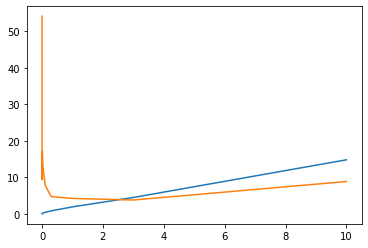

In [298]:
#Valores de lambda a probar
lamda_vector = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
costesTrain = []
costesVal = []
theta = np.zeros(p+1)

for lamda in lamda_vector :
    fun = minimize(fun=fun_coste, x0 = theta, args=(X_poly_norm_ones, Y, lamda))
    costesTrain.append(fun_coste(fun.x, X_poly_norm_ones, Y, 0))
    costesVal.append(fun_coste(fun.x, Xval_norm_ones, Yval_ravel, 0))

#Imprimos los costes obtenidos
plt.plot(lamda_vector, costesTrain)
plt.plot(lamda_vector, costesVal)
plt.show()
    

Como podemos ver, el mejor valor de $\lambda$ es 3. Para acabar, estimamos el error de la hipótesis aplicándola al conjuntos de datos de prueba.

In [299]:
#Obtenemos los datos de prueba
Xtest = dic['Xtest']
Ytest = dic['ytest']

#Generamos los datos polinomiales, normalizamos y anadimos unos
Xtest_norm = normalize_data_params(build_polynomial_data(Xtest, p), media, desviacion)
Xtest_norm_ones = np.hstack([np.ones([Xtest_norm.shape[0], 1]), Xtest_norm])
theta = np.zeros(p+1)

#Hallamos thetas optimos y calculamos el coste
fun = minimize(fun=fun_coste, x0 = theta, args=(X_poly_norm_ones, Y, 3))
fun_coste(fun.x, Xtest_norm_ones, Ytest.ravel(), 0)

3.5720273027516343

Y obtenemos el error que se nos indica en el enunciado.